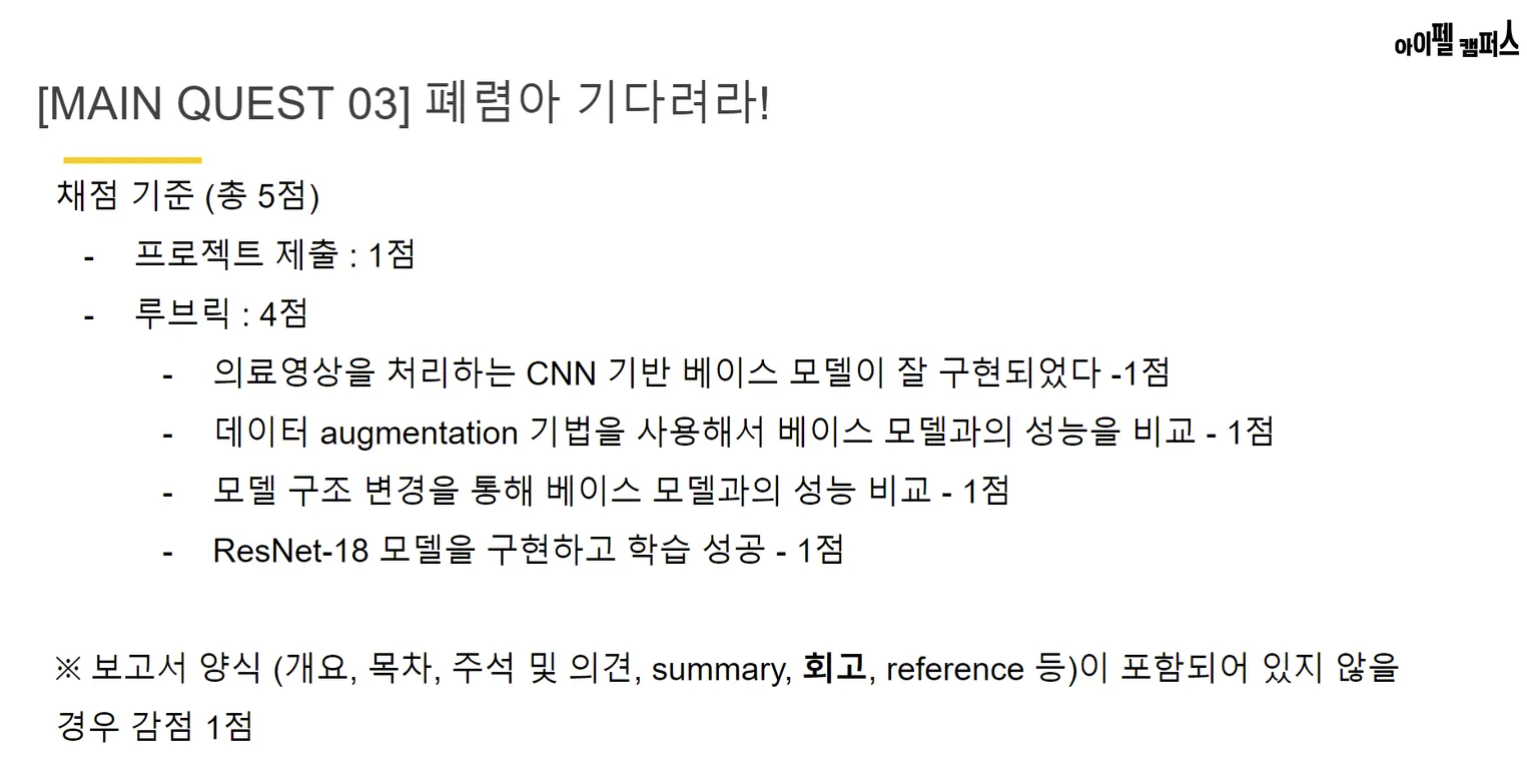

- 데이터 준비

In [1]:
# 모듈 불러오기
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
PROJECT_ROOT = os.getcwd()  # 현재 작업 디렉토리를 기준으로 설정
DATA_PATH = os.path.join(PROJECT_ROOT, 'Data', 'Chest_xray')
TRAIN_PATH = os.path.join(DATA_PATH, 'train', '*', '*')  # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = os.path.join(DATA_PATH, 'val', '*', '*')
TEST_PATH = os.path.join(DATA_PATH, 'test', '*', '*')

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(DATA_PATH)

c:\Users\FOCUS\anaconda3\envs\tf_env\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


c:\Users\FOCUS\Desktop\Projects\REesNet_project\Data\Chest_xray


In [2]:
# 데이터 로드하기
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

# train 데이터와 validation 데이터를 모두 filenames에 담기
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# train과 val로 8:2 비율로 분할
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))
print(len(test_filenames))

5216
624
16
4185
1047
624


In [3]:
# train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 한번 보겠습니다.
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])

print('Normal images count in training set:', COUNT_NORMAL)
print('Pneumonia images count in training set:', COUNT_PNEUMONIA)

Normal image path
c:\Users\FOCUS\Desktop\Projects\REesNet_project\Data\Chest_xray\train\NORMAL\NORMAL2-IM-0707-0001.jpeg
Pneumonia image path
c:\Users\FOCUS\Desktop\Projects\REesNet_project\Data\Chest_xray\train\PNEUMONIA\person610_bacteria_2475.jpeg
Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [4]:
# tf.data 인스턴스를 만들기
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")


Training images count: 4185
Validating images count: 1047


In [5]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return tf.cast(parts[-2] == "PNEUMONIA", tf.int32)

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

# 테스트 데이터셋도 똑같이 만들어 주기.  
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

Image shape:  (180, 180, 3)
Label:  0
624


In [6]:
# tf.data 파이프라인을 구축하기
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

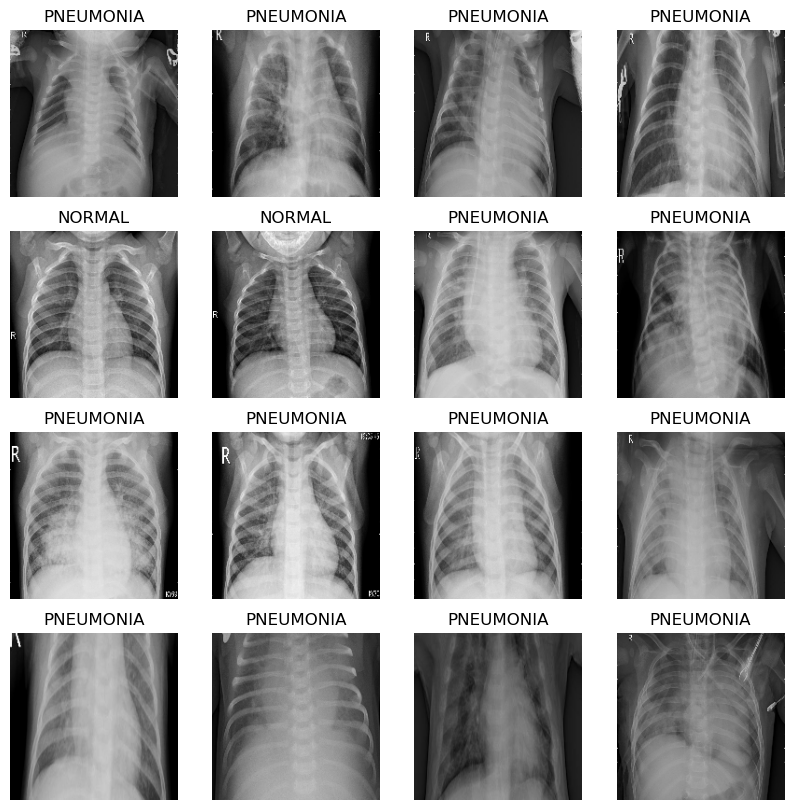

In [7]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch, batch_size):
    plt.figure(figsize=(10,10))
    for n in range(batch_size):
        ax = plt.subplot(4, math.ceil(batch_size/4), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

# 예시로 BATCH_SIZE를 16으로 설정
BATCH_SIZE = 16

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy(), BATCH_SIZE)

- CNN 베이스 모델 구현

In [8]:
# 모델 정의

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [11]:
# 클래스 불균형 해소 (반비례 가중치 설정)
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

# 모델 훈련하기
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

def process_path(file_path):
    label = get_label(file_path)  # 레이블을 정수형으로 반환
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

# train_ds와 val_ds를 다시 정의
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# 여기서 prepare_for_training 함수를 다시 적용합니다.
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67
Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 60s 203ms/step - accuracy: 0.7578 - loss: 0.4939 - precision: 0.9258 - recall: 0.7339 - val_accuracy: 0.7346 - val_loss: 0.7999 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 49s 189ms/step - accuracy: 0.9038 - loss: 0.2362 - precision: 0.9641 - recall: 0.9046 - val_accuracy: 0.7375 - val_loss: 1.3148 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 50s 192ms/step - accuracy: 0.9293 - loss: 0.1954 - precision: 0.9750 - recall: 0.9285 - val_accuracy: 0.8606 - val_loss: 0.2434 - val_precision: 0.8421 - val_recall: 0.9987
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 49s 187ms/step - accuracy: 0.9274 - loss: 0.1940 - precision: 0.9823 - recall: 0.9213 - val_accuracy: 0.9481 - val_loss: 0.1202 - val_precision: 0.9902 - val_recall: 0.9379
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 47s 181ms/step - accuracy: 0.9417 - loss: 0.1615 - precis

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.7221 - loss: 0.8829 - precision: 0.6942 - recall: 0.9997
Loss: 0.8274059891700745,
Accuracy: 0.7211538553237915,
Precision: 0.6921707987785339,
Recall: 0.9974358677864075


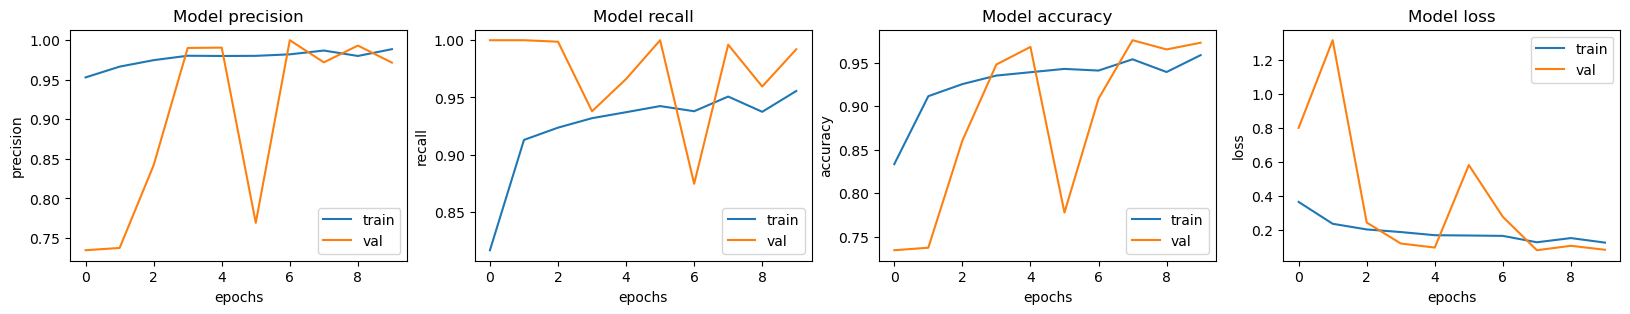

In [13]:
# 결과 확인
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

음.. Recall은 점수가 99% 이상 나오는데, Precision은 70%가 나오네.  

분석해보면  
지금 0 이 정상(음성)이고 1 이 폐렴(양성)이고..  
지금 폐렴 클래스 데이터가 정상 클래스 데이터 보다 3배 많으니까.  
폐렴 즉, '1'(양성)으로 예측하려는 경향이 강해질것임.  
   
따라서, 실제 폐렴인 샘플을 폐렴으로 잘 예측할테니 Recall이 99%가 나왔을테고.  
반면 실제 정상인 경우도 폐렴으로 예측하려 할테니 거짓양성 비율이 높아져 Precision은 낮게 나왔네.  
어쨌든 폐렴을 폐렴으로 잘 예측하니 좋은 모델이지만,  
정상인도 폐렴으로 예측하니 문제가 생기겠네  
  
그리고 훈련에서는 Precision이 90%이상 나왔는데. 테스트에서 70%가 나왔다는건.  
일단 과적합 문제가 있을 수 있고. 앞서 말한 데이터 불균형 문제가 있을 수도 있겠네.  
지금 훈련된 모델 자체가 폐렴으로 예측하는 경향이 강한 상태니까.  

그렇다면, 이를 해결하기 위해서는. 
1. 과적합 방지
2. 클래스 불균형 문제 해결.  

을 해야겠고.

1.은 모델을 수정해야 되는 부분이고
2.는 데이터 증강으로 해결 해볼 수 있는 문제겠네.

- 데이터 증강

In [16]:
def augment(image, label):
    # 이미지 좌우 반전
    image = tf.image.random_flip_left_right(image)
    
    # 이미지 회전
    image = tf.image.rot90(image, k=np.random.randint(1, 4))  # 90도 단위로 랜덤 회전
    
    # 가우시안 노이즈 추가
    def add_gaussian_noise(image, stddev=0.05):
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=stddev, dtype=tf.float32)
        image = tf.add(image, noise)
        image = tf.clip_by_value(image, 0.0, 1.0)  # 값을 0과 1 사이로 클립
        return image
    
    image = add_gaussian_noise(image)
    label = tf.cast(label, tf.int32)
    
    return image, label

# train_ds에 데이터 증강을 적용
train_ds = train_list_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# prepare_for_training 함수를 적용하여 배치 및 반복 설정
train_ds = prepare_for_training(train_ds)

# 기존 모델 정의 코드 사용
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

    # 모델 훈련하기
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,  # 불균형 데이터 가중치 적용
    )

Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 58s 196ms/step - accuracy: 0.7242 - loss: 0.5302 - precision: 0.9207 - recall: 0.6901 - val_accuracy: 0.7346 - val_loss: 0.6670 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 49s 188ms/step - accuracy: 0.8882 - loss: 0.2823 - precision: 0.9629 - recall: 0.8832 - val_accuracy: 0.7375 - val_loss: 1.3039 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 49s 187ms/step - accuracy: 0.9219 - loss: 0.1970 - precision: 0.9770 - recall: 0.9176 - val_accuracy: 0.7490 - val_loss: 0.5847 - val_precision: 0.7508 - val_recall: 0.9829
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 49s 187ms/step - accuracy: 0.9318 - loss: 0.1829 - precision: 0.9844 - recall: 0.9245 - val_accuracy: 0.7644 - val_loss: 0.4737 - val_precision: 0.7899 - val_recall: 0.9316
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 50s 192ms/step - accuracy: 0.9237 - loss: 0.1804 - precision: 0.9758 - recall: 0.9198 - val_accuracy: 0.7250

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.6764 - loss: 0.7875 - precision: 0.6824 - recall: 0.9049
Loss: 0.7920989394187927,
Accuracy: 0.6714743375778198,
Precision: 0.6748582124710083,
Recall: 0.9153845906257629


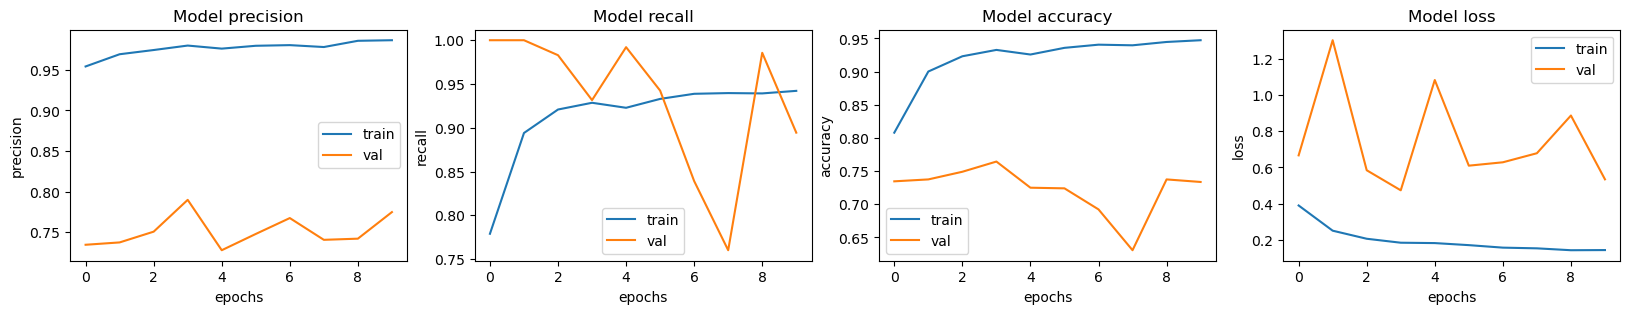

In [17]:
# 결과 확인
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

성능이 오히려 떨어짐. 좌우 반전, 90도 회전, 가우시안 노이즈를 넣었는데. 그렇게 효과적이진 않는것 같음.  
노드에서와 같이 좌우 반전 정도만 넣고, 모델 자체를 개선시켜보자.

- 모델 구조 변경

데이터 증강은 좌우 반전만 적용함.  
Inception 모듈 도입하여 모델 구조 변경하였음  
L2규제, Dropout, 배치 정규화를 적용하여 과적합 방지.  
Epoch = 10->30, Batch_ Size = 16->32 로 수정.  

In [19]:
# 데이터 증강 함수 정의 (좌우 반전만 적용)
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

# 데이터셋 생성 및 증강 적용
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [20]:
def inception_module(x, filters, l2_strength):
    f1, f3_r, f3, f5_r, f5, pool_proj = filters

    # 1x1 conv
    conv1 = tf.keras.layers.Conv2D(f1, (1,1), padding='same', activation='relu', 
                                   kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)

    # 3x3 conv
    conv3 = tf.keras.layers.Conv2D(f3_r, (1,1), padding='same', activation='relu',
                                   kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.Conv2D(f3, (3,3), padding='same', activation='relu',
                                   kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(conv3)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)

    # 5x5 conv
    conv5 = tf.keras.layers.Conv2D(f5_r, (1,1), padding='same', activation='relu',
                                   kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = tf.keras.layers.Conv2D(f5, (3,3), padding='same', activation='relu',
                                   kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(conv5)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = tf.keras.layers.Conv2D(f5, (3,3), padding='same', activation='relu',
                                   kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(conv5)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)

    # 3x3 max pooling
    pool = tf.keras.layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    pool = tf.keras.layers.Conv2D(pool_proj, (1,1), padding='same', activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(pool)
    pool = tf.keras.layers.BatchNormalization()(pool)

    # Concatenate filters
    output = tf.keras.layers.concatenate([conv1, conv3, conv5, pool], axis=-1)
    return output

def build_improved_model():
    l2_strength = 1e-4

    inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    x = tf.keras.layers.Conv2D(32, (3,3), strides=(2,2), padding='same', activation='relu',
                               kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

    x = inception_module(x, filters=[16, 16, 16, 16, 16, 16], l2_strength=l2_strength)
    x = tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = inception_module(x, filters=[32, 32, 32, 32, 32, 32], l2_strength=l2_strength)
    x = tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = inception_module(x, filters=[64, 64, 64, 64, 64, 64], l2_strength=l2_strength)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)

    model = tf.keras.Model(inputs, outputs)
    return model


In [26]:
# 하이퍼파라미터 설정
BATCH_SIZE = 32
EPOCHS = 30

# 모델 컴파일 및 훈련
with tf.device('/GPU:0'):
    model = build_improved_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=METRICS
    )

# 콜백 설정
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss'),
    lr_schedule
]

# 모델 훈련
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=callbacks
)

Epoch 1/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 48s 274ms/step - accuracy: 0.7558 - loss: 0.5447 - precision: 0.9597 - recall: 0.6987 - val_accuracy: 0.7676 - val_loss: 1.0265 - val_precision: 0.7676 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8400 - loss: 0.4435 - precision: 1.0000 - recall: 0.7895 - val_accuracy: 0.7051 - val_loss: 1.2711 - val_precision: 0.7051 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 37s 256ms/step - accuracy: 0.8547 - loss: 0.4053 - precision: 0.9890 - recall: 0.8134 - val_accuracy: 0.7324 - val_loss: 1.3634 - val_precision: 0.7324 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9600 - loss: 0.2680 - precision: 1.0000 - recall: 0.9412 - val_accuracy: 0.7402 - val_loss: 1.3544 - val_precision: 0.7402 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.7122 - loss: 0.8673 - precision: 0.6925 - recall: 0.9920
Loss: 0.9251348972320557,
Accuracy: 0.6971153616905212,
Precision: 0.6741767525672913,
Recall: 0.9974358677864075


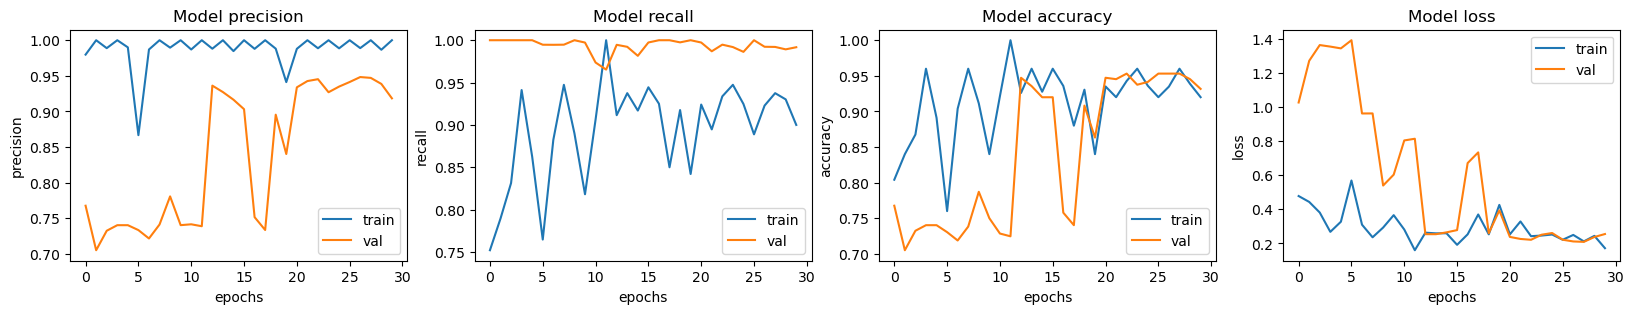

In [27]:
# 결과 확인
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

성능이 비슷하게 나왔네.. 에...?  
규제 적용했는데 30 epochs여서 충분한 학습이 이루어지지 못 한것 같음.  
100 epoch하면 성능이 더 증가할 듯.  

아쉽다.. inception 모듈의 성능을 보고싶었는데.. 아쉽지만..  
시간 상 문제로 ResNet으로 넘어가자.  

ResNet 모델의 특징은 Residual block이 추가된다는 점이다.  
초기 conv1 이후 conv2, conv3, conv4, conv5에 잔차 레이어가 적용된다.  
성능이 기대된다..  

L2규제와 배치정규화는 동일하게 적용시켜 주었다.   
이번에는 100 epochs로 충분히 학습할 수 있게 해야겠다.

- ResNet-18 구현

In [28]:
# ResNet-18

def basic_block(input_tensor, filters, stride=1):
    x = tf.keras.layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same',
                               kernel_initializer='he_normal',
                               kernel_regularizer=tf.keras.regularizers.l2(1e-4))(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same',
                               kernel_initializer='he_normal',
                               kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if stride != 1 or input_tensor.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same',
                                          kernel_initializer='he_normal',
                                          kernel_regularizer=tf.keras.regularizers.l2(1e-4))(input_tensor)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.ReLU()(x)
    return x

def build_resnet18():
    inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    # 초기 컨볼루션과 맥스풀링 레이어
    x = tf.keras.layers.Conv2D(32, kernel_size=7, strides=2, padding='same',
                               kernel_initializer='he_normal',
                               kernel_regularizer=tf.keras.regularizers.l2(1e-4))(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # 스테이지 1
    x = basic_block(x, filters=32)
    x = basic_block(x, filters=32)

    # 스테이지 2
    x = basic_block(x, filters=64, stride=2)
    x = basic_block(x, filters=64)

    # 스테이지 3
    x = basic_block(x, filters=128, stride=2)
    x = basic_block(x, filters=128)

    # 스테이지 4
    x = basic_block(x, filters=256, stride=2)
    x = basic_block(x, filters=256)

    # 글로벌 평균 풀링과 출력 레이어
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid',
                              kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)

    model = tf.keras.Model(inputs, x)
    return model


In [30]:
# 하이퍼파라미터 설정
BATCH_SIZE = 32  # 배치 크기 증가
EPOCHS = 100      # 에포크 수 증가

# 모델 컴파일 및 훈련
with tf.device('/GPU:0'):
    model = build_resnet18()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=METRICS
    )

    # 콜백 설정
    lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
        tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss'),
        lr_schedule
    ]

    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=callbacks
    )

Epoch 1/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 55s 341ms/step - accuracy: 0.8696 - loss: 0.7970 - precision: 0.9628 - recall: 0.8586 - val_accuracy: 0.7441 - val_loss: 1.8685 - val_precision: 0.7441 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9600 - loss: 0.5531 - precision: 1.0000 - recall: 0.9500 - val_accuracy: 0.7227 - val_loss: 2.0051 - val_precision: 0.7227 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 44s 312ms/step - accuracy: 0.9614 - loss: 0.5729 - precision: 0.9867 - recall: 0.9613 - val_accuracy: 0.7422 - val_loss: 2.2603 - val_precision: 0.7422 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9200 - loss: 0.6258 - precision: 1.0000 - recall: 0.8947 - val_accuracy: 0.7227 - val_loss: 2.4425 - val_precision: 0.7227 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.7609 - loss: 1.5564 - precision: 0.7314 - recall: 0.9896
Loss: 1.6036792993545532,
Accuracy: 0.7532051205635071,
Precision: 0.7201492786407471,
Recall: 0.9897435903549194


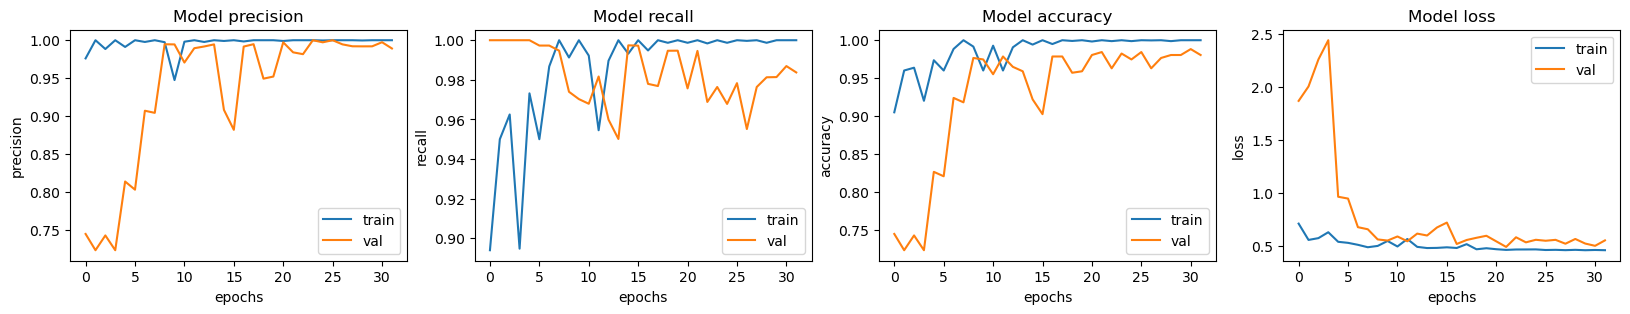

In [31]:
# 결과 확인
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

흠.. 32epochs에서 모델이 참지못하고 종료해버렸다.  

베이스 모델과 비교  
Accuracy: 72 -> 75  
Precision: 69 -> 72  
Recall: 99.7 -> 98.9  

Recall이야 항상 높게 나오니까 Precision을 높이고 싶었는데 3%증가라니..  
흠.. 일단은 요렇게 까지 프로젝트 마무리를 하고.
이어서 Precision을 높여봐야겠다.

회고:  
생각보다 Precision 성능을 올리는게 쉽지 않았다.  
하지만 inception모듈과 ResNet을 구현해보며. CNN에 좀 더 친숙해진것 같다.  
불균형한 데이터가 있을때, 어떻게 해소해줄지 이어서 공부를 해봐야겠다.  